Реализуем градиентный спуск для задачи поиска оптимальных коэффициентов в MSE регрессии!

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [277]:
data = pd.read_csv('data.csv')

data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056
3,0.606637,0.604335,0.540332,0.491236,0.325632,0.206348,0.825767,0.332475,0.955518,0.162811,31.308588
4,0.119770,0.469718,0.632829,0.504207,0.238259,0.452457,0.775360,0.174262,0.117621,0.218883,23.322751


Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [278]:
from sklearn.linear_model import LinearRegression

X = data.drop(['target'], axis=1)
Y = data['target']

In [279]:
model = LinearRegression()

model.fit(X, Y)
model.coef_

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

### Hint: пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [280]:
### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])
np.append(initial_betas, 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [281]:
### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
scalar_value = (scalar_value - Y).values

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [282]:
### Возьмем столбик со значениями 1 признака
d_i1 = X.values[:, 0]

In [283]:
### Умножим каждый объект на соответствующее значение признака
scalar_value = scalar_value * d_i1

In [284]:
### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(scalar_value)

-27.62384887912409

### Эта логика поможем Вам при реализации класса!

learn(self)

метод возвращает итоговую среднеквадратическую ошибку.
метод итеративно вычисляет среднеквадратическую ошибку и вектор-градиент. номер итерации и MSE записываются в словарь *iteration_loss_dict*. критерий останова срабатывает тогда, когда абсолютное значение разницы двух последних MSE меньше *self.threshold*.

Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

In [296]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold = 1e-6, copy: bool = True):
        """
        self.samples - матрица признаков
        self.targets - вектор таргетов
        self.beta - вектор из изначальными весами модели == коэффициентами бета (состоит из единиц)
        self.learning_rate - параметр *learning_rate* для корректировки нормы градиента
        self.threshold - величина, меньше которой изменение в loss-функции означает остановку градиентного спуска
        iteration_loss_dict - словарь, который будет хранить номер итерации и соответствующую MSE
        copy: копирование матрицы признаков или создание изменения in-place
        """
        if copy:
            self.samples = samples.copy()
        else:
            self.samples = samples
        self.targets = targets
        self.beta = np.ones(self.samples.shape[1])
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.iteration_loss_dict = {}
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        Метод создает колонку с константным признаком (interсept) в матрице признаков.
        Hint: так как количество признаков увеличилось на одну, не забудьте дополнить вектор с изначальными весами модели!
        """
        self.samples.loc[:, 'interсept'] = 1
        self.beta = np.append(self.beta, 1)
        
    def calculate_mse_loss(self, beta) -> float:
        """
        Метод для расчета среднеквадратической ошибки
        
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        return ((np.dot(self.samples, beta) - self.targets)**2).mean()
    
    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        Метод возвращает вектор-градиент, содержащий производные по каждому признаку.
        Сначала матрица признаков скалярно перемножается на вектор self.beta, и из каждой колонки
        полученной матрицы вычитается вектор таргетов. Затем полученная матрица скалярно умножается на матрицу признаков.
        Наконец, итоговая матрица умножается на 2 и усредняется по каждому признаку.
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        grad_vector = []
        for i in range(self.samples.shape[1]):
            d_i = self.samples.values[:, i] # Признаки i-ой колонки

            grad = 2 * np.mean((np.dot(self.samples, self.beta) - self.targets)*d_i)
            
            grad_vector.append(grad)
            
        return np.array(grad_vector)
    
    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        self.beta = self.beta - self.learning_rate*self.calculate_gradient()
        
    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        Запись mse и номера итерации в iteration_loss_dict
        
        Описание алгоритма работы для изменения бет:
            Фиксируем текущие beta -> start_betas
            Делаем шаг градиентного спуска
            Записываем новые beta -> new_betas
            Пока |L(new_beta) - L(start_beta)| < threshold:
                Повторяем первые 3 шага
                
        Описание алгоритма работы для изменения функции потерь:
            Фиксируем текущие mse -> previous_mse
            Делаем шаг градиентного спуска
            Записываем новые mse -> next_mse
            Пока |(previous_mse) - (next_mse)| < threshold:
                Повторяем первые 3 шага
        """
        i = 0
        start_beta = self.beta
        self.iteration_loss_dict[i] = self.calculate_mse_loss(start_beta)
        
        self.iteration() # self.beta = new_beta
        
        new_beta = self.beta
        
        while abs(self.calculate_mse_loss(start_beta) - self.calculate_mse_loss(new_beta)) > self.threshold:
            i += 1
            start_beta = new_beta
            self.iteration_loss_dict[i] = self.calculate_mse_loss(start_beta)
            
            self.iteration() # self.beta = new_beta
            
            new_beta = self.beta

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Получились ли такие же коэффициенты, как и при использовании **LinearRegression** из **sklearn**? Если нет, то почему они отличаются, на Ваш взгляд, и сильно ли?

In [297]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

11

In [223]:
GD.iteration_loss_dict

{0: 682.6688587468462,
 1: 673.1874227973021,
 2: 663.8390921185639,
 3: 654.6219976377017,
 4: 645.5342965275871,
 5: 636.5741718383537,
 6: 627.7398321340231,
 7: 619.0295111342317,
 8: 610.4414673609948,
 9: 601.9739837904258,
 10: 593.6253675093517,
 11: 585.3939493767422,
 12: 577.2780836898979,
 13: 569.2761478553289,
 14: 561.3865420642528,
 15: 553.6076889726397,
 16: 545.9380333857688,
 17: 538.3760419471961,
 18: 530.9202028321073,
 19: 523.5690254449573,
 20: 516.321040121371,
 21: 509.17479783422584,
 22: 502.1288699038542,
 23: 495.1818477123296,
 24: 488.3323424217511,
 25: 481.57898469648677,
 26: 474.9204244293277,
 27: 468.355330471472,
 28: 461.88239036631455,
 29: 455.5003100869631,
 30: 449.2078137774449,
 31: 443.00364349755165,
 32: 436.8865589712628,
 33: 430.8553373387024,
 34: 424.90877291157494,
 35: 419.0456769320439,
 36: 413.2648773349889,
 37: 407.56521851360856,
 38: 401.9455610883033,
 39: 396.40478167881537,
 40: 390.94177267956286,
 41: 385.55544203812

In [227]:
print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(np.around(GD.beta, decimals=2)))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

[0.89 1.9  2.88 3.88 4.9  5.89 6.89 7.9  8.88 9.86 4.95]


Попробуйте теперь изменить значения **learning_rate** и/или **threshold**. Например, установите длину шага $\eta = 1$. Что произошло и почему такое возможно?

In [298]:
GD = GradientDescentMse(samples=X, targets=Y, learning_rate=1)
GD.add_constant_feature()
GD.learn()

<ipython-input-296-3d128f7b12c5>:97: RuntimeWarning: invalid value encountered in double_scalars
  while abs(self.calculate_mse_loss(start_beta) - self.calculate_mse_loss(new_beta)) > self.threshold:


In [221]:
print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

[9.40188501e+152 9.18141651e+152 8.60666268e+152 8.65906169e+152
 8.84957221e+152 9.26558544e+152 9.00779348e+152 9.33707984e+152
 8.88112792e+152 8.93870956e+152 1.77388075e+153]


В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

У вас должен получиться примерно такой график (см. ниже, значения среднеквадратической ошибки мы намеренно замазали оранжевыми квадратиками, чтобы не спойлерить вам результаты).

Как и подобает хорошим Data Scientist'ам, не забывайте подписывать графики, оси, а так же делать элементы ваших визуализаций читаемыми и видимыми. Советуем пересмотреть методы и параметры форматирования из лекции.

При какой комбинации **threshold** - **learning rate** из возможных предложенных выше, получается достигнуть меньшего значения нашей минимизируемой функции? Запишите каждой из значений в легенде на графиках.


In [353]:
def draw_learning_paths(fig, learning_rates, threshold, X, Y, i):
    ax = fig.add_subplot(2, 2, i+1)
    ax.title.set_text(f'thresholds = {threshold}')
                               
    ax.set_xlabel('Номер итерации') # задать параметры оси X
    ax.set_ylabel('Среднекватратическая ошибка') # задать параметры оси Y
    
    for j in range(len(learning_rates)):
        learning_rate = learning_rates[j]
            
        GD = GradientDescentMse(samples=X, targets=Y, learning_rate=learning_rate, threshold=threshold)
        GD.add_constant_feature()
        GD.learn()
            
        X_plt = list(GD.iteration_loss_dict.values())
        Y_plt = list(GD.iteration_loss_dict.keys())
            
        ax.plot(X_plt, Y_plt, label=f'lr =  {learning_rate}, Q = {round(X_plt[-1], 2)}')
        ax.legend() # добавить легенду
        
    print(f'Ready - {i}')
    

Ready - 0
Ready - 1
Ready - 2
Ready - 3


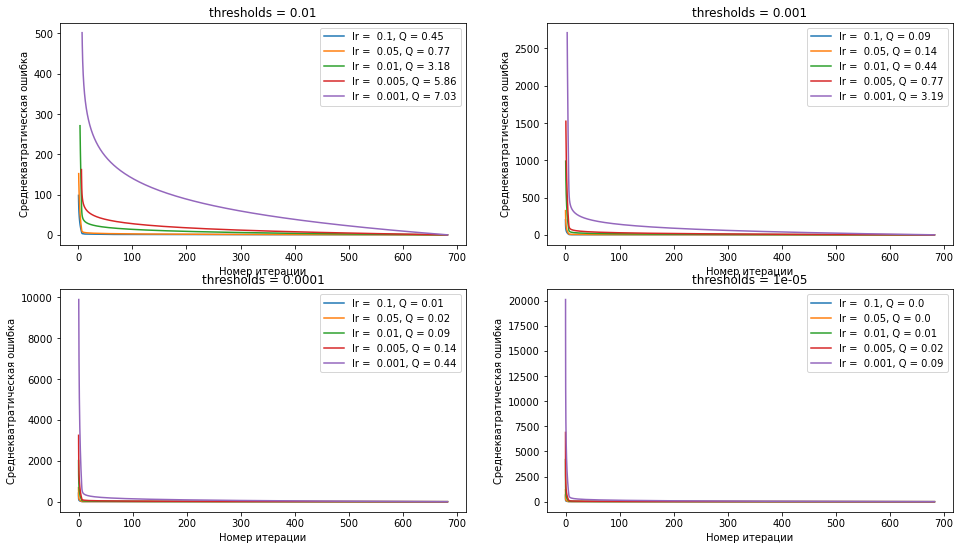

In [354]:
fig = plt.figure()
fig.set_size_inches(16, 9)

learning_rates = np.array([1e-1, 5e-2, 1e-2, 5e-3, 1e-3])
thresholds = np.array([1e-2, 1e-3, 1e-4, 1e-5])


for i in range(len(thresholds)):
    threshold = thresholds[i]
    draw_learning_paths(fig, learning_rates, threshold, X, Y, i)
plt.show()

In [320]:
len(learning_rates)

5

In [355]:
GD = GradientDescentMse(samples=X, targets=Y, learning_rate=0.1, threshold=1e-05)
GD.add_constant_feature()
GD.learn()

In [356]:
GD.calculate_mse_loss(GD.beta)

0.0010623860912254447

In [357]:
GD.beta

array([0.96264787, 1.96873788, 2.96153091, 3.96074385, 4.96725772,
       5.96628699, 6.96703209, 7.9704753 , 8.96163741, 9.95673565,
       4.55419638])